In [1]:
%matplotlib inline
import os
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from collections import Counter
#from scipy.special import digamma
from scipy import stats


import sys

try:
    origin = os.path.dirname(os.path.abspath(__file__))
except NameError:
    origin = "./"

In [2]:
import scipy
print(scipy.__version__)
# 0.22.0

1.7.3


In [3]:
proteome = '/Schubert2013AbsolutProteome.csv'
tested = '/PupProteinCat.csv'
pupylome = '/Myco_pupylomes.csv'


In [4]:
def datacheck(csvfile_path, delimeter = ' '):
    "eats list of pupylationtargets as tap delimetered file, with name file"
    with open(csvfile_path, 'r') as f:    
            info = list(line.strip().split(delimeter) for line in f)
    f.closed
    return info

In [5]:
prot_array = np.array(datacheck(origin + proteome)[1:])
prot_names = list(prot_array[:, 0])

prot_abundances = prot_array[:, 2:].astype(float)
prot_abundances_mean = np.mean(prot_abundances[:,:4], axis = 1)
prot_size =  prot_array[:, 1].astype(float)#**(2/3.)


In [6]:
#load pupylome data
pre_pup_array = np.array(datacheck(origin + pupylome, ';'))
pup_names = list(pre_pup_array[1:, 1])
pup_array=np.array(pre_pup_array)

# convert to integers
pup_sites = pup_array[:,[3,5,7]]
pup_sites[pup_sites == ''] = 0.0
pup_sites = pup_sites.astype('float')
pup_sites[pup_sites == 2.0] = 1.0
pup_sites[pup_sites == -1.0] = -3.0


In [7]:
#tested_pup_array = datacheck(origin + tested, ';')
tested_pup_array = datacheck(origin + tested, ',')
length = len(sorted(tested_pup_array,key=len, reverse=True)[0])

tested_array=np.array([xi+[0]*(length-len(xi)) for xi in tested_pup_array])
tested_names = list(tested_array[1:, 1])
tested_array[1:, 2:][tested_array[1:, 2:]==''] = np.nan
tested_sites = tested_array[1:, 2:].astype(float)[:,:2]

gen_list = list(set(list(tested_names) + list(prot_names)))

In [8]:
sizes = []
values = []
pupylations = []
analysed = []

total_count = 0
double_count = 0
pup_count = 0
prot_count = 0
for gene in gen_list:
    total_count += 1
    if gene in pup_names and gene in prot_names:
        
        pup_idx = pup_names.index(gene)
        prot_idx = prot_names.index(gene)
        values.append(prot_abundances_mean[prot_idx])
        pupylations.append(pup_sites.sum(axis=1)[pup_idx])
        sizes.append(prot_size[prot_idx])
        double_count += 1
    elif gene in pup_names and gene not in prot_names:
        
        pup_idx = pup_names.index(gene)
        values.append(0) #-10
        pupylations.append(0)
        sizes.append(prot_size[prot_idx])
        pup_count+= 1
    elif gene in prot_names and gene not in pup_names:
        
        prot_idx = prot_names.index(gene)
        values.append(prot_abundances_mean[prot_idx])
        pupylations.append(0)
        sizes.append(prot_size[prot_idx])
        prot_count += 1
    if gene in tested_names:
        try:
            prot_idx = prot_names.index(gene)
            test_idx = tested_names.index(gene)
        except ValueError:
            print('problem with: ' + str(gene))
            analysed.append(0)
            continue
        if abs(tested_sites[test_idx, 0]) > 0:
            if tested_sites[test_idx, 1] > 30:
                analysed.append(2)
            else:
                analysed.append(2)
        elif tested_sites[test_idx, 1] > 30:
            analysed.append(2)
        elif tested_sites[test_idx, 1] <= 30:# and abs(tested_sites[test_idx, 0]) < 0:
            analysed.append(1)
            
    else:
        analysed.append(0)


print(total_count, double_count, pup_count, prot_count)

sort_idx = np.argsort(values)[::-1]
np.array(analysed)[np.array(analysed)!=0]

problem with: Rv1205
problem with: Rv2111c
2025 607 2 1416


array([2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1])

In [9]:
# Transform units

#v_myco =  0.10**2*np.pi*2 * 10 ** -15 # l   old volume
v_myco = 0.0005**3*10**-6 # volume estimate from Olga's 
n_avogadro = 6.02*10**23 * 10**-6 # umol


sort_idx = sort_idx[::-1]
Mask = np.array(values)[sort_idx] > 0

truncated_values = np.array(values)[sort_idx][Mask] / (v_myco*n_avogadro) # for uM
truncated_pupylations = np.array(pupylations)[sort_idx][Mask]
truncated_analysed = np.array(analysed)[sort_idx][Mask]
truncated_sizes = np.array(sizes)[sort_idx][Mask] / 1000 # for kDa

x = np.arange(len(truncated_values))

In [10]:


# not in pupylome data
x1 = truncated_values[truncated_pupylations == 0]
y1 = truncated_sizes[truncated_pupylations == 0]

# in pupylome data
x2 = truncated_values[truncated_pupylations > 0]
y2 = truncated_sizes[truncated_pupylations > 0]


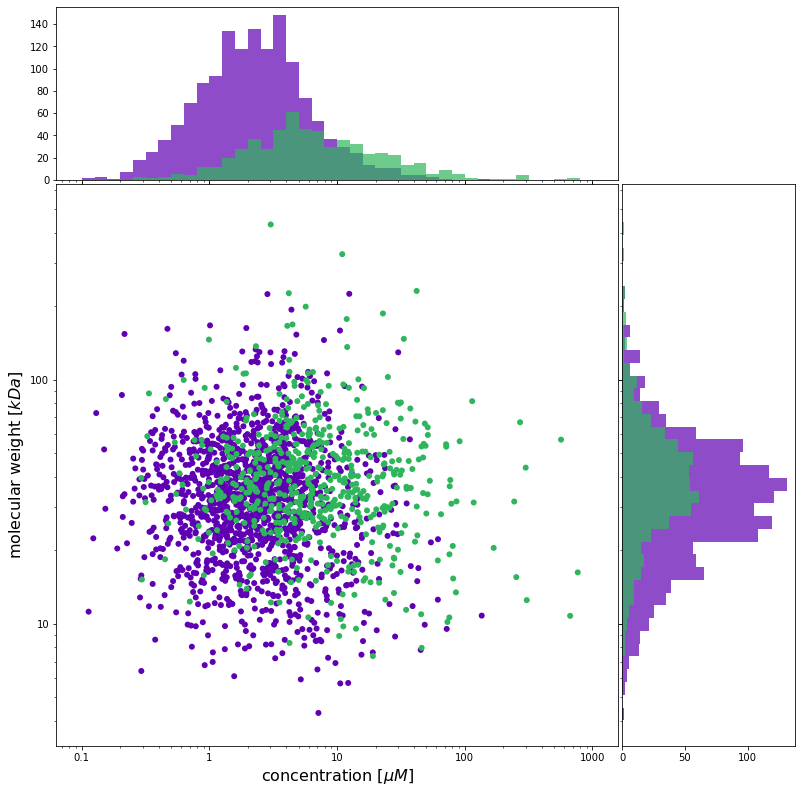

In [11]:
from matplotlib.ticker import FuncFormatter


left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(12, 12))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='out', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='out', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='out', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x1, y1, c='#5F00B3', ec=None)
ax_scatter.scatter(x2, y2, c='#2FB55C', ec=None)
# now determine nice limits by hand:
ax_histx.hist(x1, bins=np.logspace(-1.2,3.2,45), color='#5F00B3', ec=None, alpha=0.7)
ax_histy.hist(y1, bins=np.logspace(0.5,2.8,45), color='#5F00B3', ec=None, alpha=0.7, orientation='horizontal')
ax_histx.hist(x2, bins=np.logspace(-1.2,3.2,45), color='#2FB55C', ec=None, alpha=0.7)
ax_histy.hist(y2, bins=np.logspace(0.5,2.8,45), color='#2FB55C', ec=None, alpha=0.7, orientation='horizontal')
ax_histx.set_xscale('log')
ax_histy.set_yscale('log')
ax_scatter.set_xscale('log')
ax_scatter.set_yscale('log')
ax_scatter.set_xlim(10**-1.2, 10**3.2)
ax_scatter.set_ylim(10**0.5, 10**2.8)
ax_histx.set_xlim(10**-1.2, 10**3.2)
ax_histy.set_ylim(10**0.5, 10**2.8)

formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax_scatter.xaxis.set_major_formatter(formatter)

formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax_scatter.yaxis.set_major_formatter(formatter)
ax_scatter.set_xlabel('concentration [$\mu$$M$]', fontdict={'fontsize': 16, 'fontweight': 'light'})
ax_scatter.set_ylabel('molecular weight [$kDa$]', fontdict={'fontsize': 16, 'fontweight': 'light'})
plt.savefig('pup_dist.svg',dpi=600)

plt.show()



In [12]:
print('no pup mean concentration {} and variance {} in uM'.format(np.mean(x1), np.var(x1)))
print('pup mean concentration {} and variance {} in uM'.format(np.mean(x2), np.var(x2)))
print('mean difference: {}, fold change {}'.format(np.mean(x2) - np.mean(x1), np.mean(x2) / np.mean(x1)))

print('\ntest statistics if groups are different:')
print('students t:  {}'.format(stats.ttest_ind(x1, x2, equal_var=True)))
print('walds t:  {}'.format(stats.ttest_ind(x1, x2, equal_var=False)))
print('Man U:  {}'.format(stats.mannwhitneyu(x1, x2, alternative='two-sided')))

no pup mean concentration 3.966355087561237 and variance 47.03374846699044 in uM
pup mean concentration 17.83698396648852 and variance 3159.2391535817546 in uM
mean difference: 13.870628878927285, fold change 4.4970718891070876

test statistics if groups are different:
students t:  Ttest_indResult(statistic=-9.115900721778509, pvalue=1.8527415202900722e-19)
walds t:  Ttest_indResult(statistic=-5.894587049225805, pvalue=6.3713553978081314e-09)
Man U:  MannwhitneyuResult(statistic=202091.0, pvalue=1.3490649505927827e-69)


In [13]:
print('no pup mean size {} and variance {} in kDa'.format(np.mean(y2), np.var(y2)))
print('pup mean size {} and variance {} in kDa'.format(np.mean(y1), np.var(y1)))
print('mean difference: {}, fold change {}'.format(np.mean(y2) - np.mean(y1), np.mean(y2) / np.mean(y1)))

print('\ntest statistics if groups are different:')
print('students t:  {}'.format(stats.ttest_ind(y1, y2, equal_var=True)))
print('walds t:  {}'.format(stats.ttest_ind(y1, y2, equal_var=False)))
print('Man U:  {}'.format(stats.mannwhitneyu(y1, y2, alternative='two-sided')))

no pup mean size 44.94837147826087 and variance 1143.2719715025255 in kDa
pup mean size 37.07428891242938 and variance 568.0438906282034 in kDa
mean difference: 7.874082565831486, fold change 1.2123866106894272

test statistics if groups are different:
students t:  Ttest_indResult(statistic=-5.873723072947139, pvalue=4.982527330559327e-09)
walds t:  Ttest_indResult(statistic=-5.089906331999512, pvalue=4.4504260932797487e-07)
Man U:  MannwhitneyuResult(statistic=330361.5, pvalue=4.091836258853991e-11)


In [14]:
triple_pupyome_genes = np.array(gen_list)[sort_idx][Mask][truncated_pupylations == 3]
double_pupyome_genes = np.array(gen_list)[sort_idx][Mask][truncated_pupylations == 2]
single_pupyome_genes = np.array(gen_list)[sort_idx][Mask][truncated_pupylations == 1]
zero_pupyome_genes = np.array(gen_list)[sort_idx][Mask][truncated_pupylations == 0]


triple_pupyome_values = truncated_values[truncated_pupylations == 3]
double_pupyome_values = truncated_values[truncated_pupylations == 2]
single_pupyome_values = truncated_values[truncated_pupylations == 1]
zero_pupyome_values = truncated_values[truncated_pupylations == 0]


print('triple')
for p in tested_pup_array:
    if p[1] in triple_pupyome_genes:
        IDX =  list(triple_pupyome_genes).index(p[1])
        print(p, triple_pupyome_values[IDX])
print('double')
for p in tested_pup_array:
    if p[1] in double_pupyome_genes:
        IDX =  list(double_pupyome_genes).index(p[1])
        print(p, double_pupyome_values[IDX])
print('single')
for p in tested_pup_array:
    if p[1] in single_pupyome_genes:
        IDX =  list(single_pupyome_genes).index(p[1])
        print(p, single_pupyome_values[IDX])
print('zero')
for p in tested_pup_array:
    if p[1] in zero_pupyome_genes:
        IDX =  list(zero_pupyome_genes).index(p[1])
        print(p, zero_pupyome_values[IDX])

triple
['FabD', 'Rv2243', '1', '3', '3', '1', '3'] 10.461794019933556
['Icl1', 'Rv0467', '1', '2', '1', '2', '2'] 43.67441860465117
double
['Mpa', 'Rv2115c', '1', '3', '1', '0.5', '3'] 4.2558139534883725
['PanB', 'Rv2225', '1', '3', '1', '0.5', '3'] 0.6544850498338871
['PckA', 'Rv0211', '', '2', '1', '1.5', '2'] 41.06644518272426
['Ino1', 'Rv0046c', '1', '2', '1', '1', '2'] 22.674418604651166
['Kgd', 'Rv1248c', '', '2', '1', '1', '2'] 11.993355481727576
['ClpP2', 'Rv2460c', '', '1', '2', '1', '1'] 31.90365448504984
single
['IdeR', 'Rv2711', '', '2', '1', '0.5', '2'] 22.990033222591368
['RecA', 'Rv2737c', '1', '2', '1', '1.5', '2'] 5.2990033222591375
['Adk', 'Rv0733', '0', '1', '1', '1.5', '1'] 29.976744186046517
['Icd2', 'Rv0066c', '', '1', '4', '2', '1'] 14.332225913621265
['Mdh', 'Rv1240', '', '1', '1', '1', '1'] 47.162790697674424
['PafA', 'Rv2097c', '', '1', '3', '1', '1'] 5.943521594684387
zero


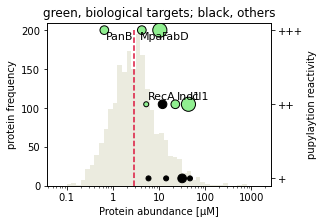

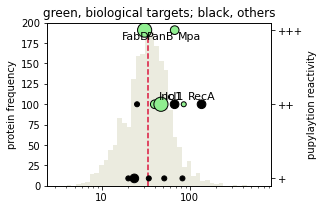

In [15]:
all_pupyome_genes = np.array(gen_list)[sort_idx][Mask]

colr_pick = {'' : 'k',
             '1' : 'lightgreen',
             '-1': 'b',
             '0' : 'k'}

abundance = []
sizes = []
pupylation_reactivity = []
colors = []
nr_pupylomes = []
names = []
for p in tested_pup_array[1:]:
    if p[1] in all_pupyome_genes:
        IDX =  list(all_pupyome_genes).index(p[1])
        try:
            react = int(p[-1])
            pupylation_reactivity.append(react)
            abundance.append(truncated_values[IDX])
            sizes.append(truncated_sizes[IDX])
            colors.append(colr_pick[p[2]])
            names.append(p[0])
        except ValueError:
            print('failed to process line {}'.format(p))
            continue
    if p[1] in triple_pupyome_genes:
        nr_pupylomes.append(200)
    elif p[1] in double_pupyome_genes:
        nr_pupylomes.append(75)
    elif p[1] in single_pupyome_genes:
        nr_pupylomes.append(25)
    elif p[1] in zero_pupyome_genes:
        nr_pupylomes.append(5)
    else:
        continue

nr_pupylomes = np.array(nr_pupylomes)
pupylation_reactivity = np.array(pupylation_reactivity) -1
colors = np.array(colors)
sizes = np.array(sizes)

values0, base0 = np.histogram(truncated_values, bins=np.logspace(-1.2,3.2,45))

formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
f, ax1 = plt.subplots(1, 1, figsize=(4,3))
ax1.hist(truncated_values, bins=np.logspace(-1.2,3.2,45), color=(0.7,0.7,0.5,.25), ec=None)
ax1.set_ylabel('protein frequency')
ax1.vlines(x=np.median(truncated_values), ymin=0, ymax=200, ls='--', color='crimson')
ax1.set_xlabel(r'Protein abundance [μM]')
ax1.set_xticks(np.logspace(-1,3,5).astype(int))
ax1.set_xticklabels(np.logspace(-1,3,5).astype(int))
ax3 = ax1.twinx()
ax3.scatter(np.array(abundance), pupylation_reactivity, color=colors, s=nr_pupylomes, label='abundance', ec='k')
ax3.set_xscale('log')
ax3.xaxis.set_major_formatter(formatter)
ax3.set_ylabel('pupylaytion reactivity')
ax3.set_title('green, biological targets; black, others')
ax3.set_yticks(np.arange(3))
ax3.set_yticklabels(['+', '++', '+++'])
for i, c in enumerate(colors):
    if c =='lightgreen':
        if pupylation_reactivity[i] < 2:
            ax3.text(np.array(abundance)[i]*1.1, pupylation_reactivity[i]+.06, names[i], size =11)
        elif names[i] == 'Mpa':
            ax3.text(np.array(abundance)[i]*.9, pupylation_reactivity[i]-.12, names[i], size =11)
        else:
            ax3.text(np.array(abundance)[i]*1.1, pupylation_reactivity[i]-.12, names[i], size =11)

plt.savefig('pupylation_histograms1.svg')
plt.show()

formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
f, ax2 = plt.subplots(1, 1, figsize=(4,3))
ax2.hist(truncated_sizes, bins=np.logspace(0.5,2.8,45), color=(0.7,0.7,0.5,.25), ec=None)
ax2.set_ylabel('protein frequency')
ax2.vlines(x=np.median(truncated_sizes), ymin=0, ymax=200, ls='--', color='crimson')
ax2.set_ylim([0, 200])
ax4 = ax2.twinx()
ax4.scatter(sizes, pupylation_reactivity, color=colors, s=nr_pupylomes, ec='k')
ax4.set_xscale('log')
ax4.xaxis.set_major_formatter(formatter)
ax4.set_xlabel('protein size /kDa')
ax4.set_ylabel('pupylaytion reactivity')
ax4.set_yticks(np.arange(3))
ax4.set_yticklabels(['+', '++', '+++'])
ax4.set_title('green, biological targets; black, others')
for i, c in enumerate(colors):
    if c =='lightgreen':
        if pupylation_reactivity[i] < 2:
            ax4.text(np.array(sizes)[i]*1.1, pupylation_reactivity[i]+.06, names[i], size =11)
        elif names[i] == 'FabD':
            ax4.text(np.array(sizes)[i]*.55, pupylation_reactivity[i]-.12, names[i], size =11)
        else:
            ax4.text(np.array(sizes)[i]*1.1, pupylation_reactivity[i]-.12, names[i], size =11)



plt.savefig('pupylation_histograms2.svg')
plt.show()

